In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import models
import utils
from counterfactual_search import *

## Load MNIST dataset

In [2]:
# define transfroms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))        
])

# load mnist train dataset
train_ds = datasets.MNIST(
    'dataset/',
    train=True,
    download=True, 
    transform=transform
)

# load mnist test dataset
test_ds = datasets.MNIST(
    'dataset/',
    train=False,
    download=True,
    transform=transform
)

## Load/Train & test the auto-encoder

Auto-encoder loaded ...


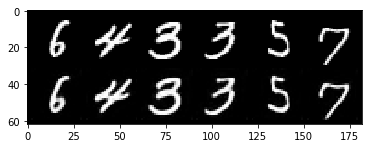

In [3]:
# define auto-encoder
ae = models.AE()

# train autoencoder if necessary
ae_root_dir = os.path.join("ckpts", "ae")
ae_path = os.path.join(ae_root_dir, "ckpt.pt")

if os.path.exists(ae_path):
    # load pre-trained auto-encoder
    ae.load_state_dict(torch.load(ae_path))
    print("Auto-encoder loaded ...")
    
else:
    # train the auto-encoder
    utils.fit(
        model=ae,
        train_ds=train_ds,
        optimizer=torch.optim.Adam(ae.parameters(), lr=1e-3),
        criterion=torch.nn.MSELoss(reduction='mean'),
        epochs=4, 
        batch_size=128, 
        vis_inter=100,
        tuple_flag=False
    )
    print("Auto-encoder trained ... ")
    
    # save the autoencoder
    if not os.path.exists(ae_root_dir):
        os.makedirs(ae_root_dir)
        
    torch.save(ae.cpu().state_dict(), ae_path)
    print("Auto-encoder saved ...")
    
# test the autoencoder
utils.display_ae(ae, test_ds, batch_size=6)

## Load/Train & test the classifier

In [4]:
# define auto-encoder
clf = models.Classifier()

# train the classifier if necessary
clf_root_dir = os.path.join("ckpts", "clf")
clf_path = os.path.join(clf_root_dir, "ckpt.pt")

if os.path.exists(clf_path):
    # load pre-trained classifier
    clf.load_state_dict(torch.load(clf_path))
    print("Classifier loaded ...")
    
else:
    # train the classifier
    utils.fit(
        model=clf,
        train_ds=train_ds,
        optimizer=torch.optim.Adam(clf.parameters(), lr=1e-3),
        criterion=torch.nn.CrossEntropyLoss(reduction='mean'),
        epochs=3, 
        batch_size=32, 
        vis_inter=300,
    )
    print("Classifier trained ... ")
    
    # save the classifier
    if not os.path.exists(clf_root_dir):
        os.makedirs(clf_root_dir)
        
    torch.save(clf.cpu().state_dict(), clf_path)
    print("Classifier saved ...")
    
# test the classifier
train_acc, _ = utils.test_classifier(clf, train_ds, batch_size=128)
test_acc, _  = utils.test_classifier(clf, test_ds, batch_size=128)
print("Train accuracy: %.3f \tTest accuracy: %.3f" % (train_acc, test_acc))

Classifier loaded ...
Train accuracy: 0.991 	Test accuracy: 0.986


## Counterfactual Search

In [5]:
# create counterfactul search object
ctf_search = CounterFactualSearch(dataset=test_ds, ae=ae, clf=clf)

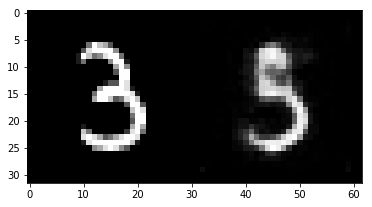

Original prediction: 3; 	Counterfactual prediction: 5



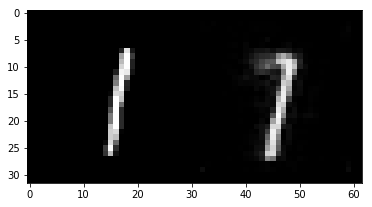

Original prediction: 1; 	Counterfactual prediction: 7



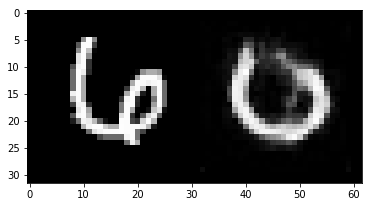

Original prediction: 6; 	Counterfactual prediction: 0



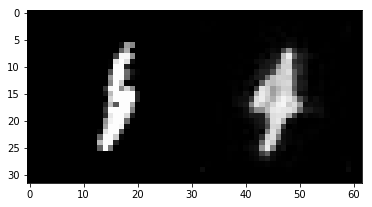

Original prediction: 1; 	Counterfactual prediction: 4



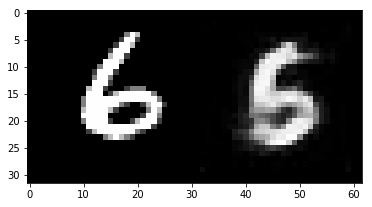

Original prediction: 6; 	Counterfactual prediction: 5



In [7]:
for i in range(5):
    # select a random image
    rand_idx = np.random.randint(low=0, high=len(test_ds)-1)
    img = test_ds[rand_idx][0]

    # search counterfactual for the selected image
    # play with those a little bit
    result = ctf_search.search(img=img, beta=0.1, c=1., gamma=100., theta=100., 
                               K=10, num_iters=100, verbose=False)

    # display original image and the counterfactual
    both = torch.cat((result['img'], result['ctf']), dim=0)
    utils.show(make_grid(both, normalize=True))

    # send models and data to device 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf = clf.to(device)
    img = result['img'].to(device)
    ctf = result['ctf'].to(device)

    # compute the predictions for the two instances
    with torch.no_grad():
        t0 = torch.argmax(clf(img)).item()
        t1 = torch.argmax(clf(ctf)).item()

    print(f"Original prediction: {t0}; \tCounterfactual prediction: {t1}")
    print("=============================================================\n")